### Fit EBLM


The following command import everything from matplotlib and numpy, and sets up inline plotting for the notebook.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Properties of the binary
These variables are used to set initial values for the model parameters and also control some of the plotting functions.

In [2]:
star_name =   'J0642-60'  # Target identifier 
star_tzero  =  2458414.5574 # BJD of mid-transit
star_period =  5.011500 # Orbital period in days
star_pwidth =  0.057 # Transit width in normalised phase units   
star_pdepth =  0.008 # Transit depth
star_phsec  =  0.499 # Phase of the secondary eclipse in normalised phase units
star_swidth =  star_pwidth # Width of the secondary eclipse in normalised phase units
star_sdepth =  0.00083 # Eclipse depth
star_teff   =  6968 # Star effective temperature (e.g. from TESS input catalogue)
star_logg   =  4.5 # Star surface gravity  (e.g. from TESS input catalogue)
star_ecc    =  0.0 # Eccentricity, e.g. from EBLM IV. Table B.1
star_omega  =  0 # Longitude of periastron (degrees), e.g. from EBLM IV. Table B.1
star_a      =  0.0715 # Semi-major axis of the orbit in au, e.g. from EBLM IV. Table B.1

#### Load nightfall curve.dat



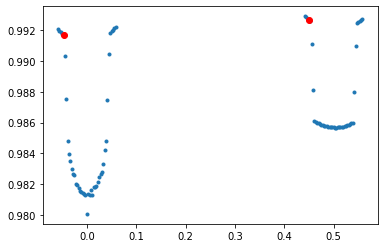

In [3]:
file = f'NightfallCurve(-60)0.53,0.107.dat'
phase, mag = np.loadtxt(file, unpack=True, usecols = [1, 6])   #  Use I band as approx. to TESS 
flux = 10**(-0.4*(mag))     # convert magnitudes to flux
# Sort out phase 
phase = phase -0.5
phase[phase < -0.25] += 1
isort = argsort(phase)
phase = phase[isort]
flux = flux[isort]


# Select regions of data around transit and eclipse
j = (abs(phase) < 0.06)  |  (abs(phase-0.5) < 0.06)
phase = phase[j]
flux = flux[j]

# Plot input data
plot(phase, flux, '.')

# Find the point of first contact for the transit
k = phase  < 0
i = np.argmin(gradient(gradient(flux[k])))-1
plot(phase[k][i], flux[k][i],'ro')
# Divide fluxes by flux value at first/last contact
flux_norm = flux[k][i] 
flux /= flux_norm

# Find the point of first/last contact for the eclipse
l = abs(phase-0.4) < 0.1
j = np.argmin(gradient(gradient(flux[l]))) - 1
# Divide fluxes around eclipse by flux value at first/last contact of the eclipse
plot(phase[l][j], flux[l][j]*flux_norm,'ro')
flux[abs(phase-0.5)<0.1] /= flux[l][i]

flux_err = np.ones_like(flux) * 1e-6


#### Initiate EBLMModel and setup a Parameters object


In [4]:
from pycheops.models import EBLMModel

model = EBLMModel()
f_c = sqrt(star_ecc)*cos(np.radians(star_omega))
f_s = sqrt(star_ecc)*sin(np.radians(star_omega))
    
par0 = model.make_params(
    P = 1, 
    T_0 = 0,
    D = star_pdepth,
    W = star_pwidth,
    L = star_sdepth,
    f_c = f_c, f_s=f_s)

par0['T_0'].vary = True
par0['T_0'].min = -0.1
par0['T_0'].max = +0.1
par0['P'].vary = False
par0['L'].max = 10*star_sdepth
par0['f_c'].vary = True
par0['f_c'].min = f_c - 0.1
par0['f_c'].max = f_c + 0.1
par0['f_s'].vary = True
par0['f_s'].min = f_s - 0.1
par0['f_s'].max = f_s + 0.1

# Light travel time across the orbit in phase units
from pycheops.constants import au,c
par0['a_c'].value = star_a * au / c / 86400 / star_period


#### Limb-darkening coefficients
The limb-darkening law used in `pycheops` is the power-2 law


In [5]:
from pycheops.ld import stagger_power2_interpolator
sp2I = stagger_power2_interpolator()
c, alpha, h_1, h_2 = sp2I(star_teff, star_logg, 0)

par0['h_1'].value = h_1
par0['h_2'].value = h_2

par0['h_1'].vary = True
par0['h_2'].vary = False


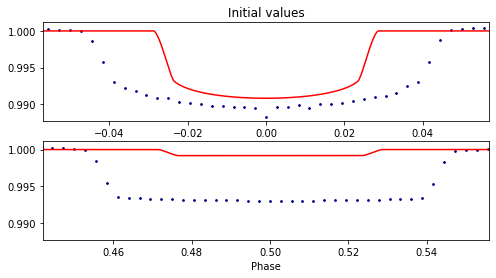

In [6]:
def plot_fit(params, title=None):
    ph_plot = np.linspace(-1,1,10001)
    lc_plot = model.eval(params, t=ph_plot )
    fig,ax=subplots(figsize=(8,4), nrows=2)
    ax[0].scatter(phase, flux, s=3, c='navy')
    ax[0].plot(ph_plot, lc_plot,c='r')
    ax[0].set_xlim(-star_pwidth, star_pwidth)
    ax[1].scatter(phase, flux, s=3, c='navy')
    ax[1].set_xlim(star_phsec-star_swidth, star_phsec+star_swidth)
    ax[1].plot(ph_plot, lc_plot,c='r')
    ax[1].set_xlabel('Phase')
    ax[0].set_title(title)
    return fig

plot_fit(par0, title='Initial values');


#### Initial optimisation using Powell method


In [7]:
result_powell = model.fit(flux, par0, t=phase, weights=1/flux_err, method='powell')
print(result_powell.fit_report())

[[Model]]
    Model(_eblm_func)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 1364
    # data points      = 86
    # variables        = 8
    chi-square         = 3466879.03
    reduced chi-square = 44447.1670
    Akaike info crit   = 927.979951
    Bayesian info crit = 947.614729
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    T_0: -1.6220e-05 (init = 0)
    P:    1 (fixed)
    D:    0.00854160 (init = 0.008)
    W:    0.09247141 (init = 0.057)
    b:    0.03995085 (init = 0.3)
    L:    0.00688275 (init = 0.00083)
    f_c:  3.0633e-04 (init = 0)
    f_s: -0.04923346 (init = 0)
    h_1:  0.71486584 (init = 0.7893691)
    h_2:  0.4847516 (fixed)
    a_c:  8.240039e-05 (fixed)
    e:    0.00242403 == 'f_c**2 + f_s

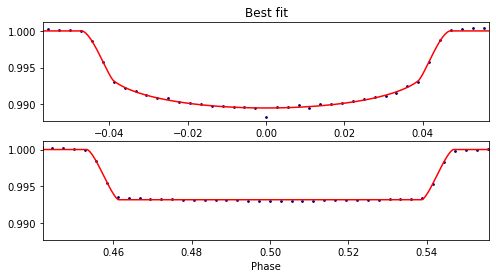

In [8]:
fig = plot_fit(result_powell.params, title='Best fit')
fig.savefig(f'{star_name.replace(" ","_")}_lcfit.png')

#### LM fit to the data

In [9]:
result_lm = model.fit(flux, result_powell.params, t=phase, weights=1/flux_err)
print(result_lm.fit_report())

[[Model]]
    Model(_eblm_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 86
    # variables        = 8
    chi-square         = 3465644.46
    reduced chi-square = 44431.3393
    Akaike info crit   = 927.949321
    Bayesian info crit = 947.584099
[[Variables]]
    T_0: -1.9913e-05 +/- 1.0127e-04 (508.55%) (init = -1.622038e-05)
    P:    1 (fixed)
    D:    0.00853872 +/- 7.5654e-05 (0.89%) (init = 0.008541603)
    W:    0.09246799 +/- 2.1529e-04 (0.23%) (init = 0.09247141)
    b:    0.00787373 +/- 1.68080997 (21347.07%) (init = 0.03995085)
    L:    0.00688237 +/- 4.0150e-05 (0.58%) (init = 0.006882754)
    f_c:  4.3877e-04 +/- 0.00459297 (1046.78%) (init = 0.0003063275)
    f_s: -0.04911582 +/- 0.02173965 (44.26%) (init = -0.04923346)
    h_1:  0.71479820 +/- 0.01202366 (1.68%) (init = 0.7148658)
    h_2:  0.4847516 (fixed)
    a_c:  8.240039e-05 (fixed)
    e:    0.00241256 +/- 0.00213536 (88.51%) == 'f_c**2 + f_s**2'
 

#### Sampling the posterior probability distribution using Goodman-Weare algorithm



In [10]:
emcee_kws = dict(steps=8000, is_weighted=False)
par1 = result_lm.params.copy()
par1.add('__lnsigma',value=np.log(np.median(flux_err)))
result_emcee = model.fit(flux, par1, t=phase, method='emcee',
                         fit_kws=emcee_kws)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [11:38<00:00, 11.46it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 160;
tau: [107.33984698  53.71202972  76.55888658 174.4924038   59.87901608
 121.87950363 156.5515481   86.3359011   25.83785106]


#### Check trail plot for convergence and choose burn-in


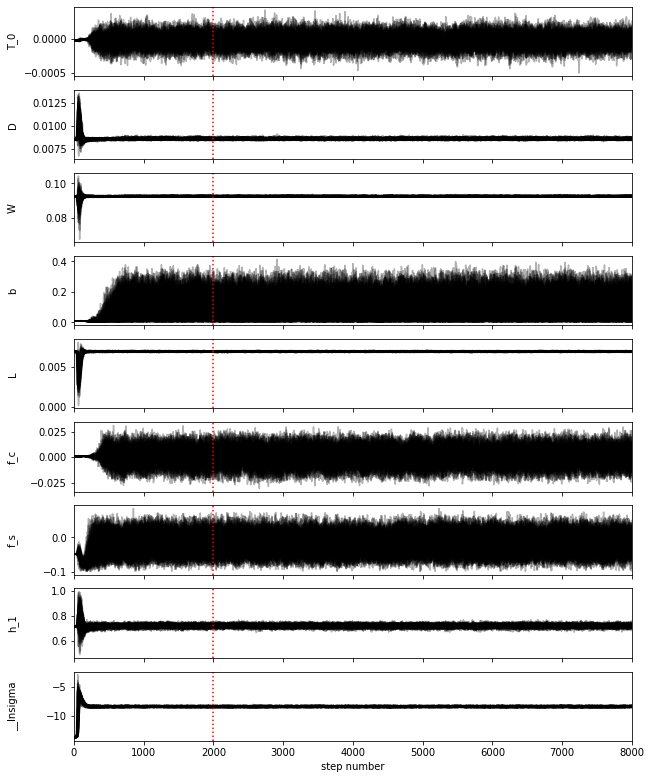

In [11]:
burn_in_steps = 2000

labels = result_emcee.var_names
n = len(labels)
fig, axes = plt.subplots(n, figsize=(10, 1.5*n), sharex=True)
samples = result_emcee.sampler.get_chain()
for i in range(n):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(burn_in_steps,ls=':',c='r')
ax.set_xlim(0, len(samples))
ax.set_xlabel("step number");

#### Parameter correlation (corner) plot


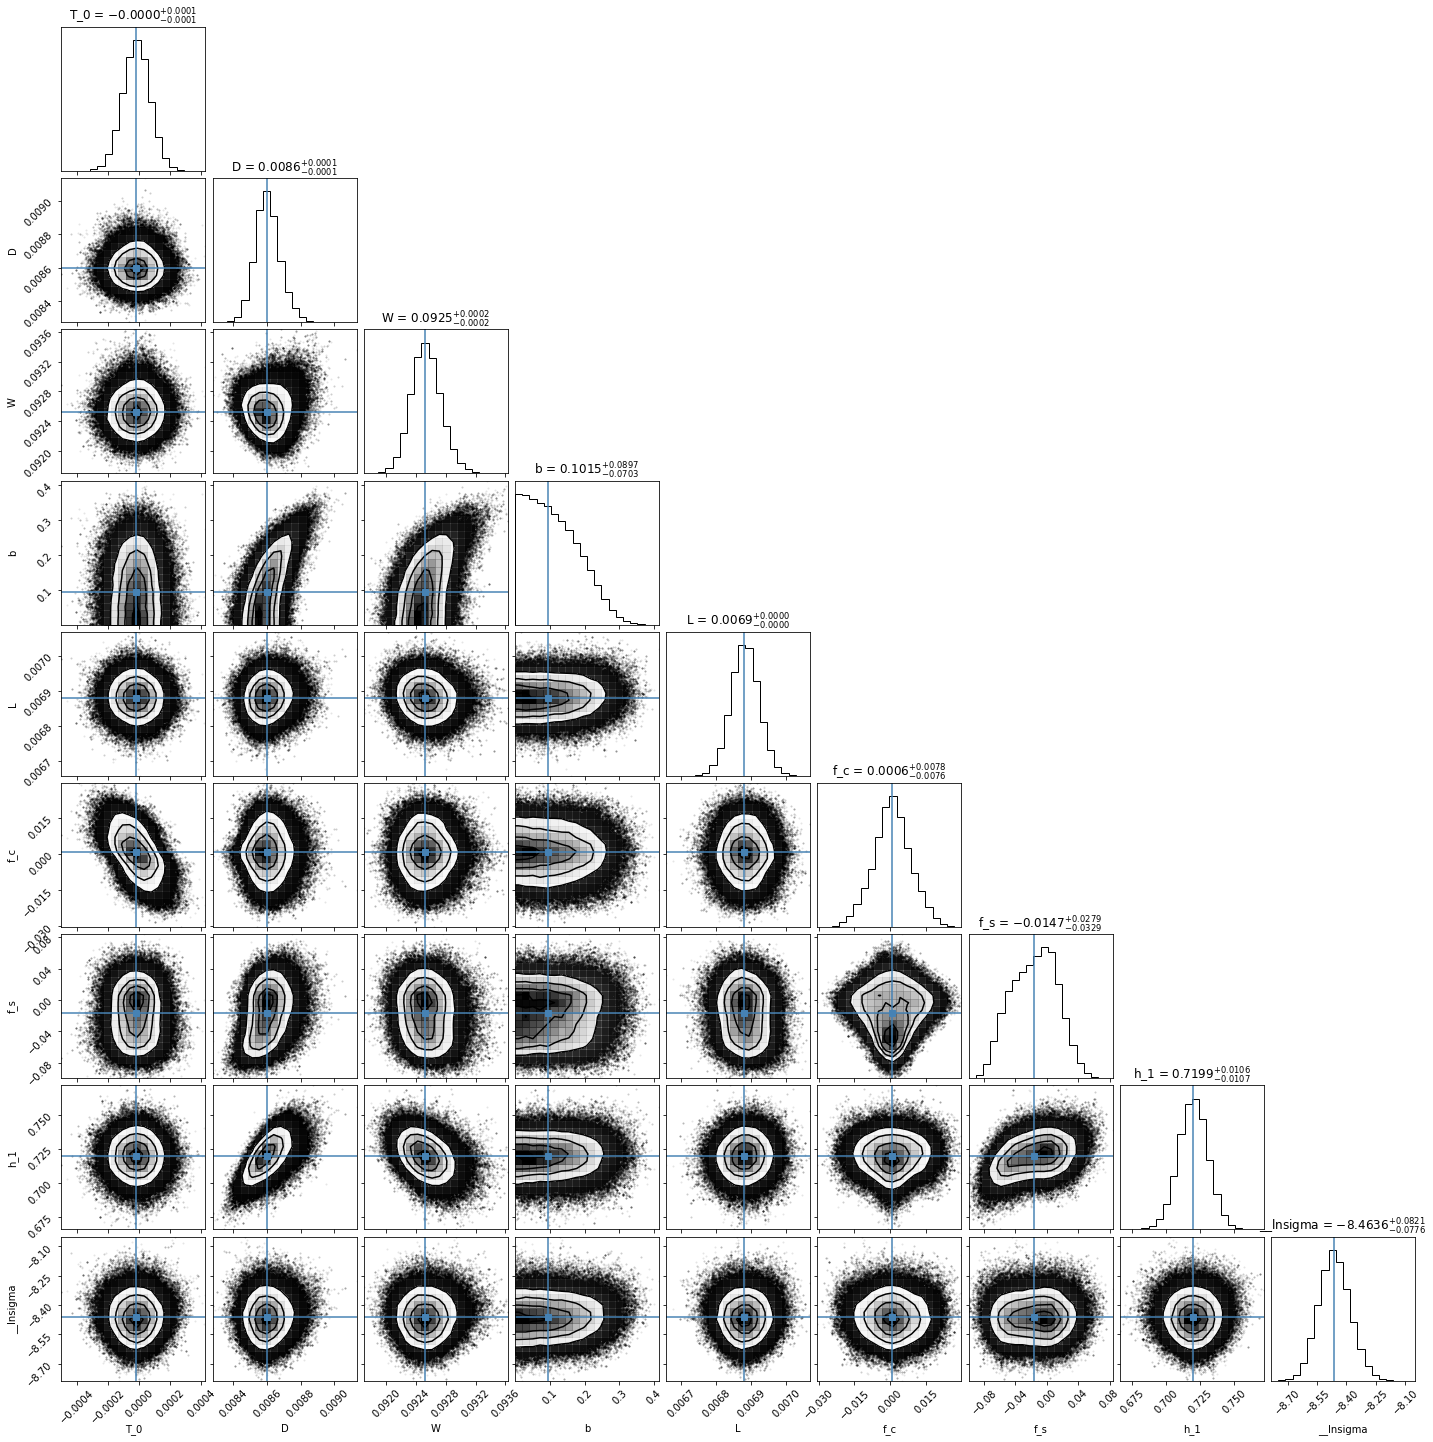

In [12]:
import corner
means = [result_emcee.params[v].value for v in labels]
flatchain = result_emcee.sampler.get_chain(flat=True, discard=burn_in_steps)
emcee_plot = corner.corner(
    flatchain,
    show_titles=True, title_fmt='0.4f',
    truths=means,labels=labels)

#### Save the chain as an astropy table for later analysis, if needed

In [13]:
from astropy.table import Table, Column

T = Table()
n_steps, n_walkers, n_var = samples.shape
for i in range(n_var):
    T[labels[i]] = flatchain[:,i]
    
lnprob = result_emcee.sampler.get_log_prob(flat=True, discard=burn_in_steps)
T.add_column(Column(lnprob,name='log_prob'))
indices_ = np.mgrid[0:n_walkers,0:n_steps-burn_in_steps]
step_ = indices_[1].flatten()
walker = indices_[0].flatten()
T.add_column(Column(step_,name='step'))
T.add_column(Column(walker,name='walker'))
Te = T['f_c']**2 + T['f_s']**2
T.add_column(Column(Te,name='e'))
Tom = np.degrees(np.arctan2(T['f_s'], T['f_c']))
T.add_column(Column(Tom,name='omega'))
Tk = np.sqrt(T['D'])
T.add_column(Column(Tk,name='k'))
Tr1 = np.pi*T['W']/np.sqrt((1+Tk)**2-T['b']**2)
T.add_column(Column(Tr1,name='r_1'))
Tr2 = Tk*Tr1
T.add_column(Column(Tr2,name='r_2'))
Tsigma = exp(T['__lnsigma'])
T.add_column(Column(Tsigma,name='sigma'))
T.write(f'chain_{star_name}.fits',overwrite=True)



#### Use the table to print mean, standard error and confidence limits on parameters

In [14]:
from pycheops.utils import parprint
p = T.colnames
p.remove('step')
p.remove('walker')
p.remove('log_prob')
p.remove('__lnsigma')
for v in p:
    print(parprint(T[v], v, wn=12, sf=2))

    T_0          = -0.000019 +/- 0.000089 (-0.000090,+0.000087)
    D            = 0.008599 +/- 0.000072 (-0.000068,+0.000076)
    W            =  0.09253 +/-  0.00020 (-0.00019,+0.00021)
    b            =    0.102 +/-    0.080 (  -0.071,  +0.090)
    L            = 0.006881 +/- 0.000040 (-0.000039,+0.000040)
    f_c          =   0.0006 +/-   0.0077 ( -0.0077, +0.0078)
    f_s          =   -0.015 +/-    0.031 (  -0.033,  +0.028)
    h_1          =    0.720 +/-    0.011 (  -0.011,  +0.011)
    e            =   0.0006 +/-   0.0011 ( -0.0004, +0.0018)
    omega        =      -81 +/-       93 (     -18,    +168)
    k            =  0.09273 +/-  0.00039 (-0.00037,+0.00041)
    r_1          =   0.2672 +/-   0.0023 ( -0.0013, +0.0033)
    r_2          =  0.02476 +/-  0.00027 (-0.00016,+0.00039)
    sigma        = 0.000211 +/- 0.000017 (-0.000016,+0.000018)
